In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings 
warnings.simplefilter(action='ignore')
import itertools
import numpy as np
import datetime as datetime 
import datetime as timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

# Sensordaten Temperatur einlesen 

In [3]:
def parse_date(x):
    try:
        return pd.to_datetime(x, format='%m/%d/%Y %H:%M:%S')
    except ValueError:
        return pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S')

#Sensordaten Temperatur einlesen 
temperature_data = pd.read_csv(
    'Sensor_Temp_23-04.csv',
    sep='|',
    header=0,
    parse_dates=['Date'],
    date_parser=parse_date
)

temperature_data.rename(columns={'Date': 'Datum', 'Value': 'Innenraum Temperatur'}, inplace=True)

temp_index = temperature_data.set_index('Datum')

print(temp_index.head(10))

                     Innenraum Temperatur
Datum                                    
2024-03-25 00:10:34                  12.2
2024-03-25 00:25:34                  12.2
2024-03-25 00:40:34                  12.1
2024-03-25 00:55:34                  12.1
2024-03-25 01:10:34                  12.1
2024-03-25 01:25:34                  12.0
2024-03-25 01:40:34                  12.0
2024-03-25 01:55:34                  12.0
2024-03-25 02:10:34                  11.9
2024-03-25 02:25:34                  11.9


# Täglicher Mittelwert bilden 

In [4]:
temp_index.index = pd.to_datetime(temp_index.index)

daily_avg = temp_index.resample('D').mean()
daily_avg = daily_avg
daily_avg.head(24)


print(daily_avg.head(10))

            Innenraum Temperatur
Datum                           
2024-03-25             12.448958
2024-03-26             12.463542
2024-03-27             13.917978
2024-03-28             14.976042
2024-03-29             14.493750
2024-03-30             15.451042
2024-03-31             17.179167
2024-04-01             17.075789
2024-04-02             16.333333
2024-04-03             15.793750


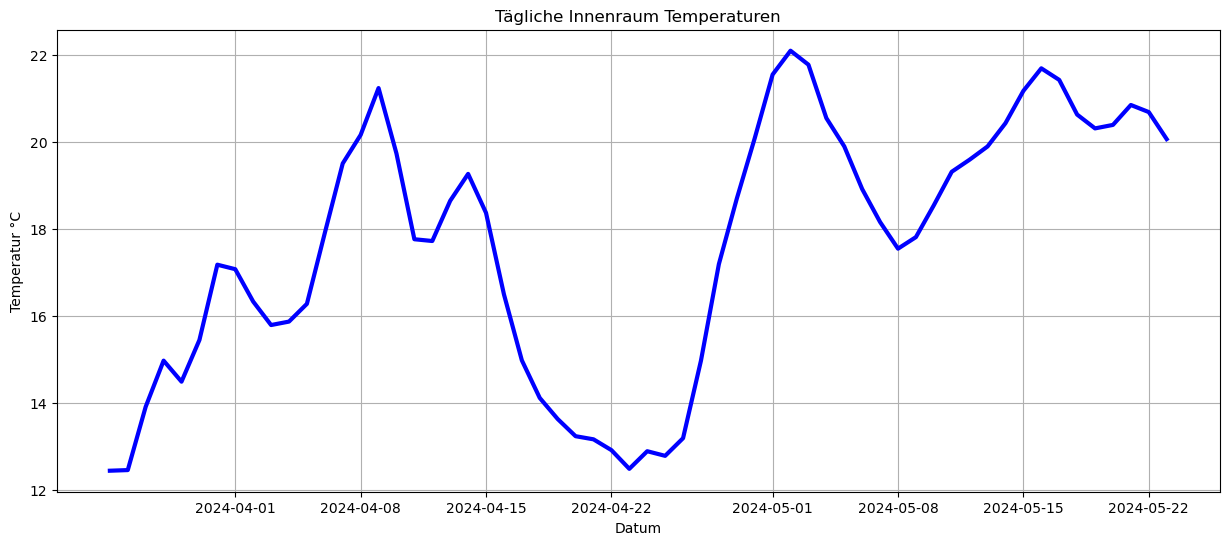

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(daily_avg['Innenraum Temperatur'], linewidth=3,c='blue')
plt.title("Tägliche Innenraum Temperaturen")
plt.xlabel("Datum")
plt.ylabel("Temperatur °C")
plt.grid(True)
plt.show()


# Außentemperaturen historisch einbinden 

In [6]:
outdoor_data = pd.read_csv(
    'Temp_24.csv',
    sep=',',
    header=0,
    parse_dates=['Datum'],
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
    index_col='Datum'
)

outdoor_data.rename(columns={'Temp': 'Außentemperatur'}, inplace=True)


print(outdoor_data.head(10))

            Außentemperatur
Datum                      
2024-03-25              5.1
2024-03-26              8.1
2024-03-27             13.0
2024-03-28              9.9
2024-03-29             11.2
2024-03-30             17.0
2024-03-31             15.4
2024-04-01             13.8
2024-04-02             10.7
2024-04-03             11.0


In [7]:
# Daten auf gleiche Frequenz bringen (falls notwendig)
outdoor_data_daily = outdoor_data.resample('D').mean()

# Daten zusammenführen
data_sum = daily_avg.join(outdoor_data_daily, how='inner')

# Den Index zurück in eine Spalte konvertieren und dann als Index setzen
data_sum.reset_index(inplace=True)
data_sum.set_index('Datum', inplace=True)

# Überprüfen, ob Daten erfolgreich zusammengeführt wurden
print(data_sum.head(10))

            Innenraum Temperatur  Außentemperatur
Datum                                            
2024-03-25             12.448958              5.1
2024-03-26             12.463542              8.1
2024-03-27             13.917978             13.0
2024-03-28             14.976042              9.9
2024-03-29             14.493750             11.2
2024-03-30             15.451042             17.0
2024-03-31             17.179167             15.4
2024-04-01             17.075789             13.8
2024-04-02             16.333333             10.7
2024-04-03             15.793750             11.0


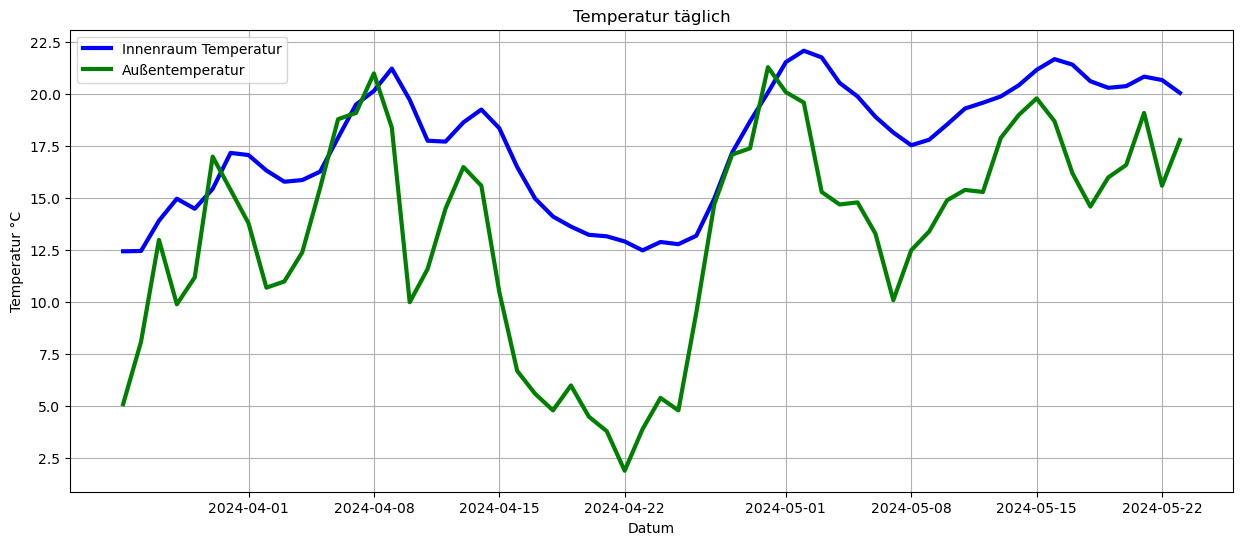

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(daily_avg.index, daily_avg['Innenraum Temperatur'], linewidth=3,c='blue', label='Innenraum Temperatur')
plt.plot(outdoor_data.index, outdoor_data['Außentemperatur'], linewidth=3,c='green', label='Außentemperatur')

plt.title("Temperatur täglich")
plt.xlabel("Datum")
plt.ylabel("Temperatur °C")

plt.grid(True)
plt.legend()
plt.show()

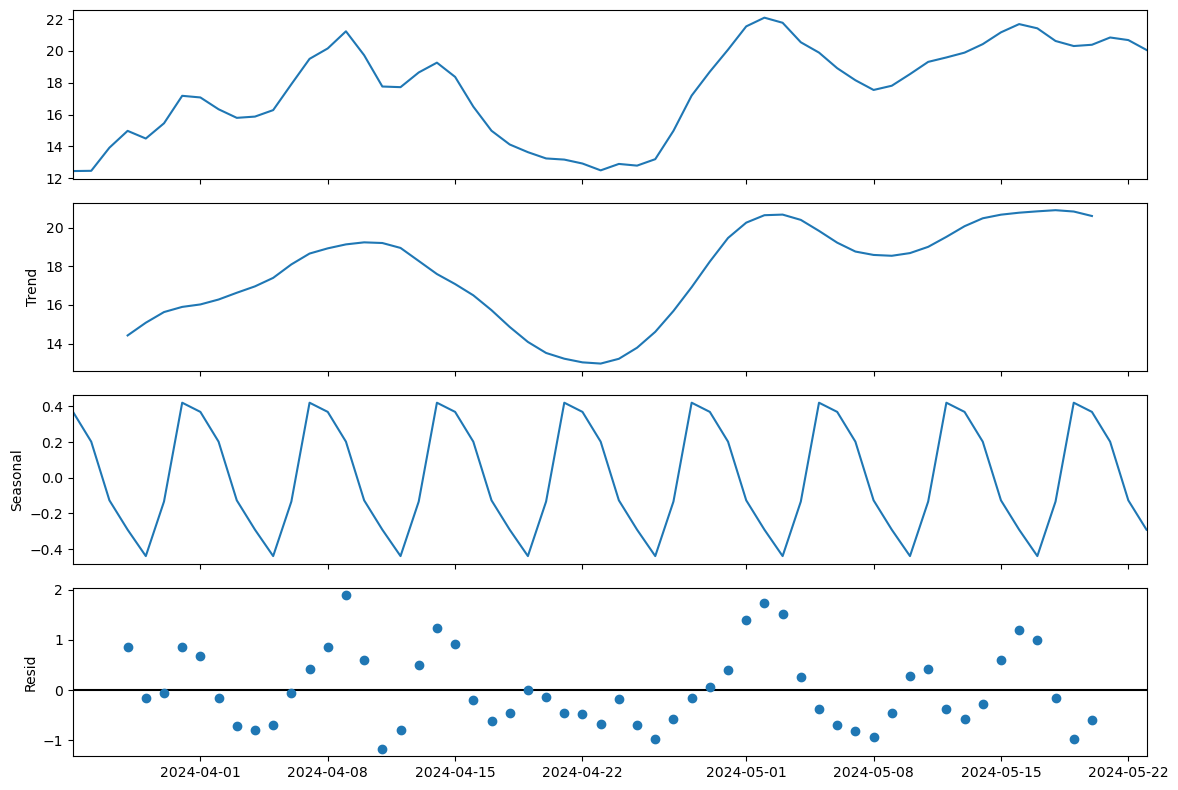

In [12]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(daily_avg, model='additive')
fig = decomposition.plot()
plt.show()

# AR(p) und MA(q) 

## ACF und PACF 

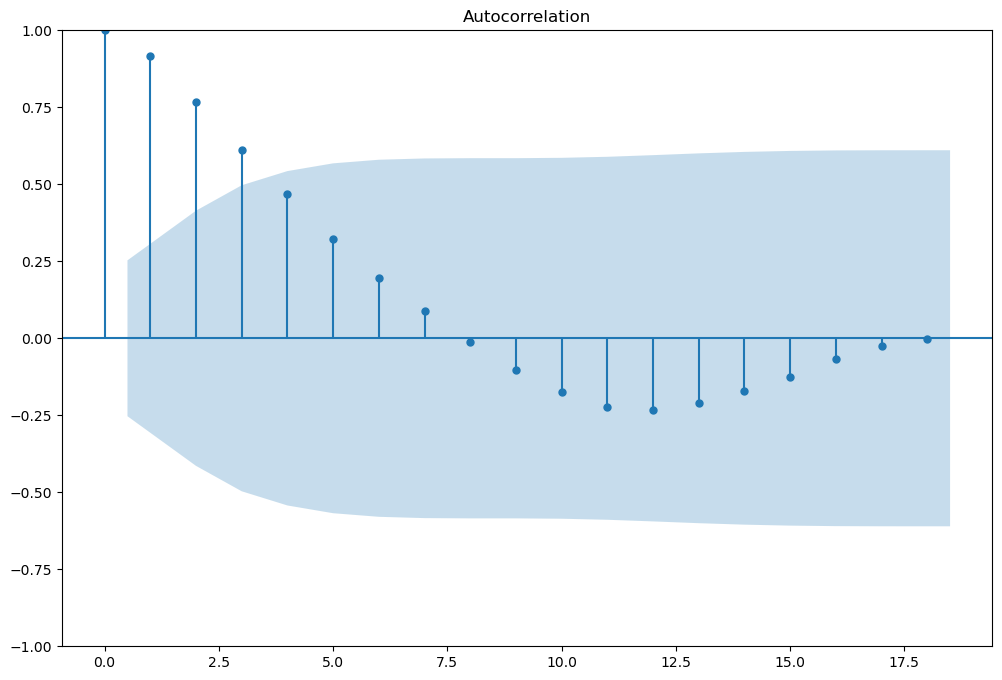

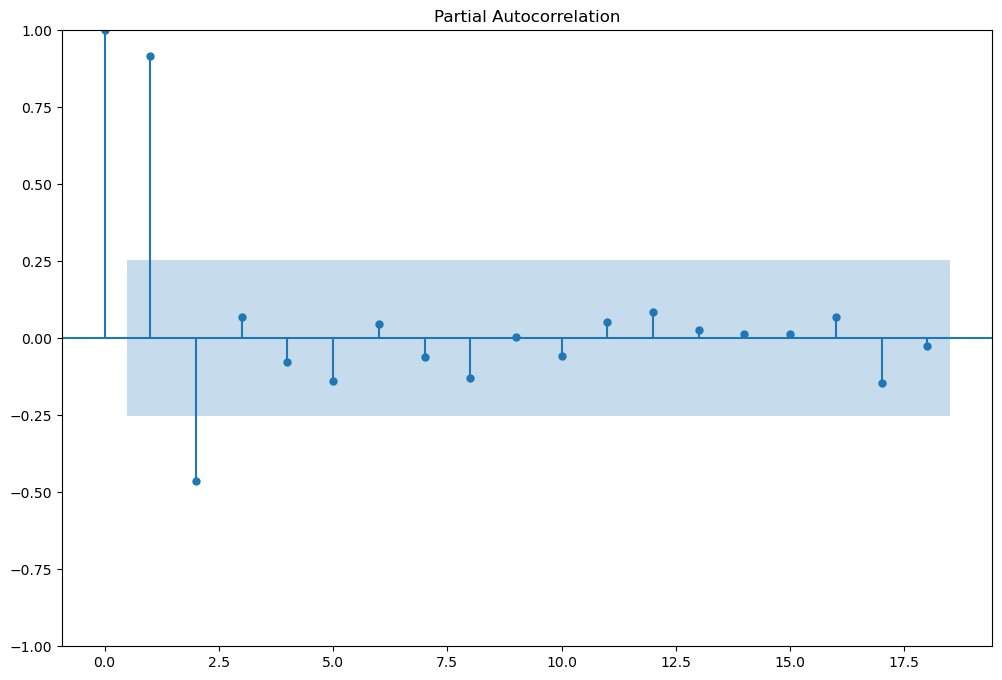

In [13]:
plot_acf(daily_avg)
plot_pacf(daily_avg)
plt.show()

#Lag 0 wird nicht berücksichtigt 
# AR
# ACF ist geometric decay/sine function decay - kein Wert für p ablesbar
# PACF p=2
# --> AR(2) 
# MA
# ACF GD
# PACF kein GD, somit keine MA 
# --> MA(0) 

## Stationarität Dickey Fuller Test ADF 

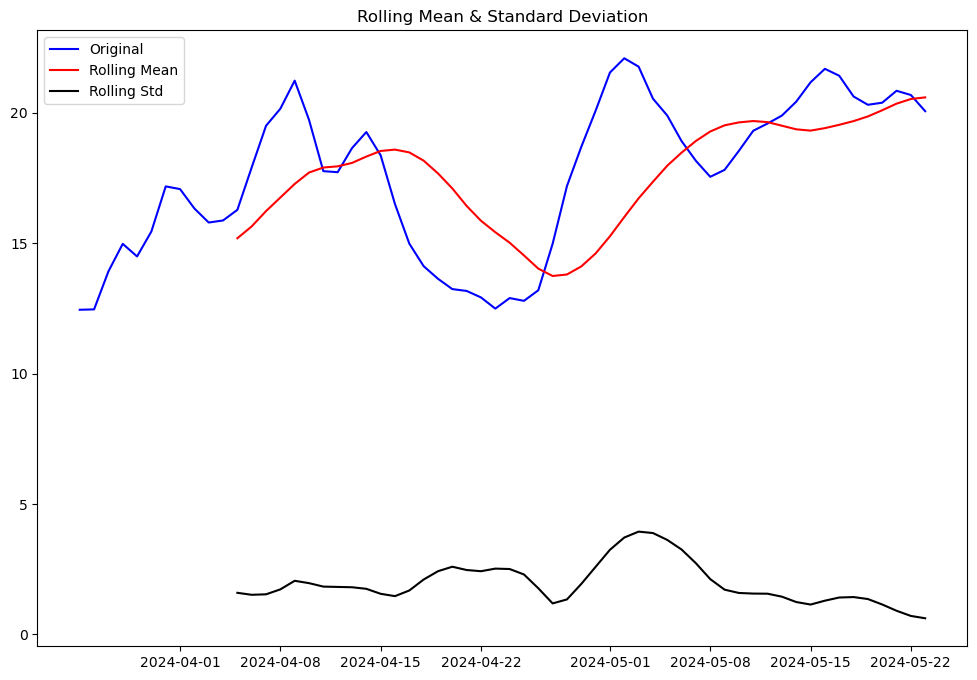

Results of Dickey-Fuller Test:
Test Statistic                 -1.940751
p-value                         0.313140
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [14]:
def test_stationarity(timeseries):
    plt.figure(figsize=(12,8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(daily_avg)

In [15]:
# Stationarität ist nicht vorhanden, daher muss differenziert werden 

# Differenzierung

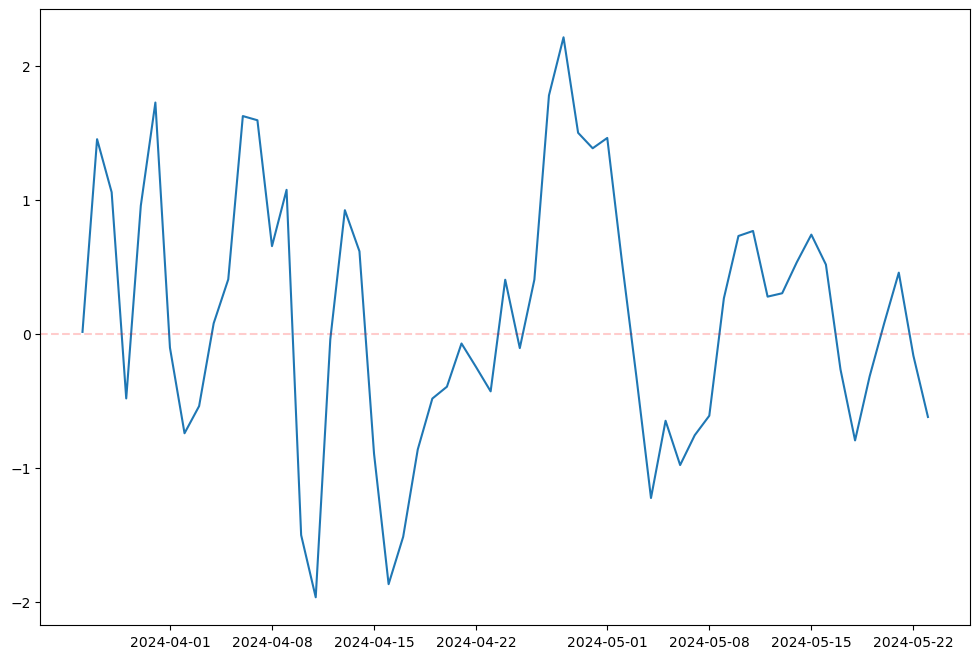

In [16]:
daily_avg = daily_avg - daily_avg.shift(1)
daily_avg = daily_avg.dropna()

plt.plot(daily_avg)
plt.axhline(0, color='red', linestyle='--', alpha=0.2)


In [17]:
# erneute Überprüfung der Stationarität mit ADF

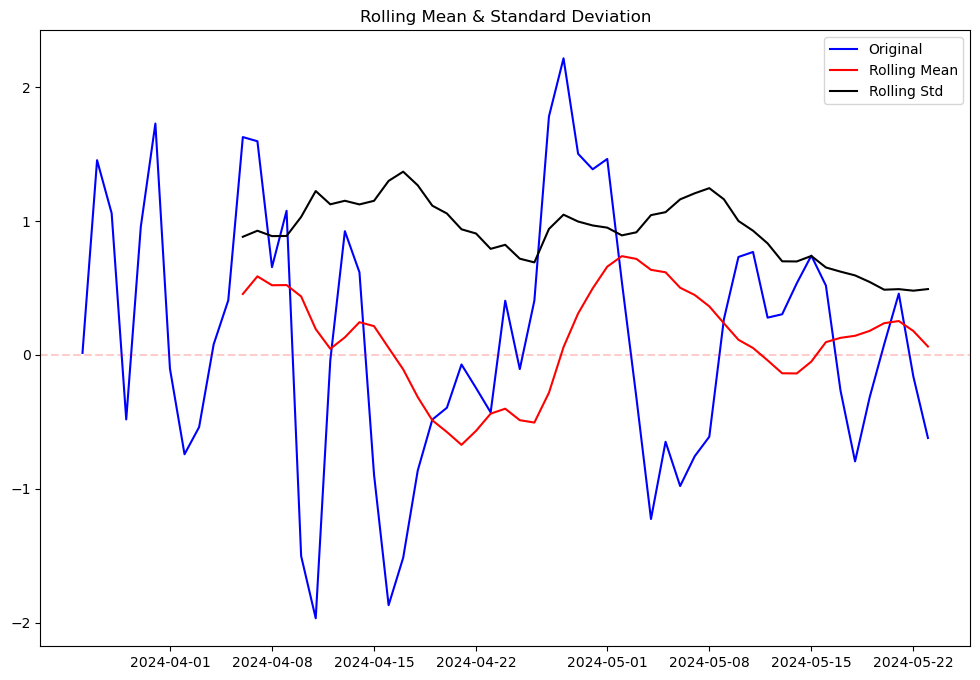

Results of Dickey-Fuller Test:
Test Statistic                 -4.763049
p-value                         0.000064
#Lags Used                      1.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [18]:
def test_stationarity(timeseries):
    plt.figure(figsize=(12,8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.axhline(0, color='red', linestyle='--', alpha=0.2)
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(daily_avg)

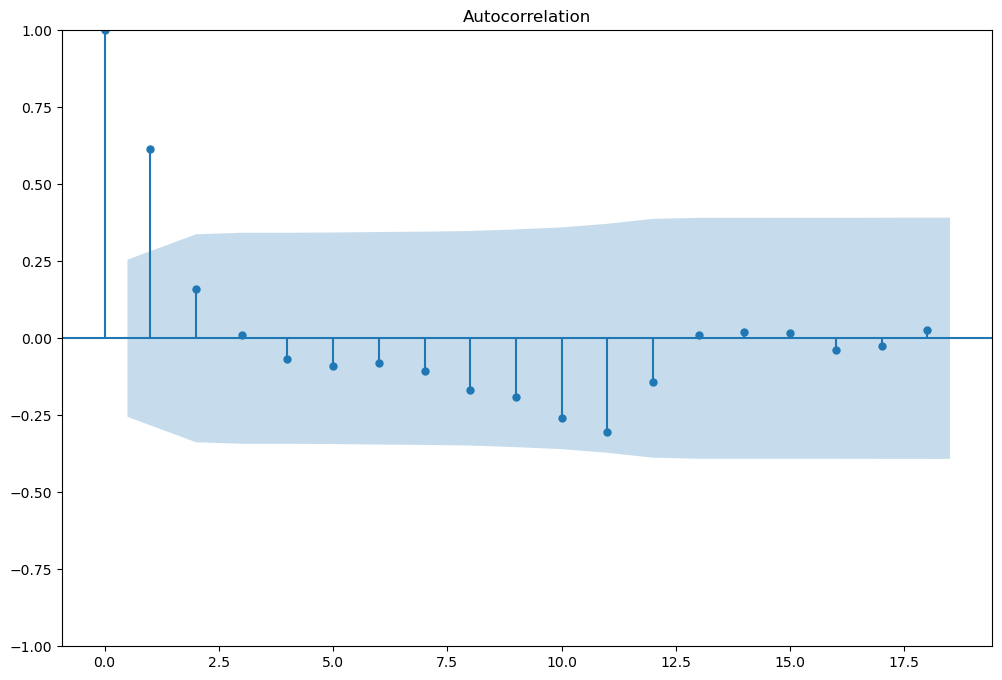

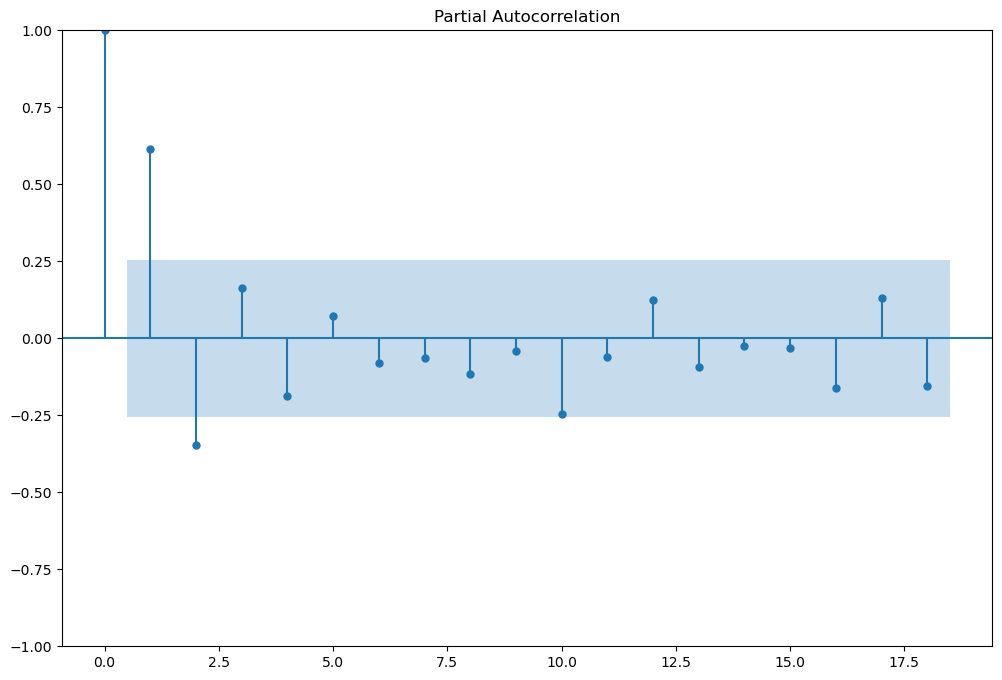

In [19]:
plot_acf(daily_avg)
plot_pacf(daily_avg)
plt.show()

In [20]:
#Lag 0 wird nicht berücksichtigt 
# AR
# ACF ist geometric decay/sine function decay - kein Wert für p ablesbar
# PACF p=2
# --> AR(2) 
# MA
# ACF GD
# PACF kein GD, somit keine MA 
# --> MA(0) 
# einmal differenziert 
# --> I(1) 
# -----> ARIMA (p,i,q) = ARIMA (2, 1, 0) 

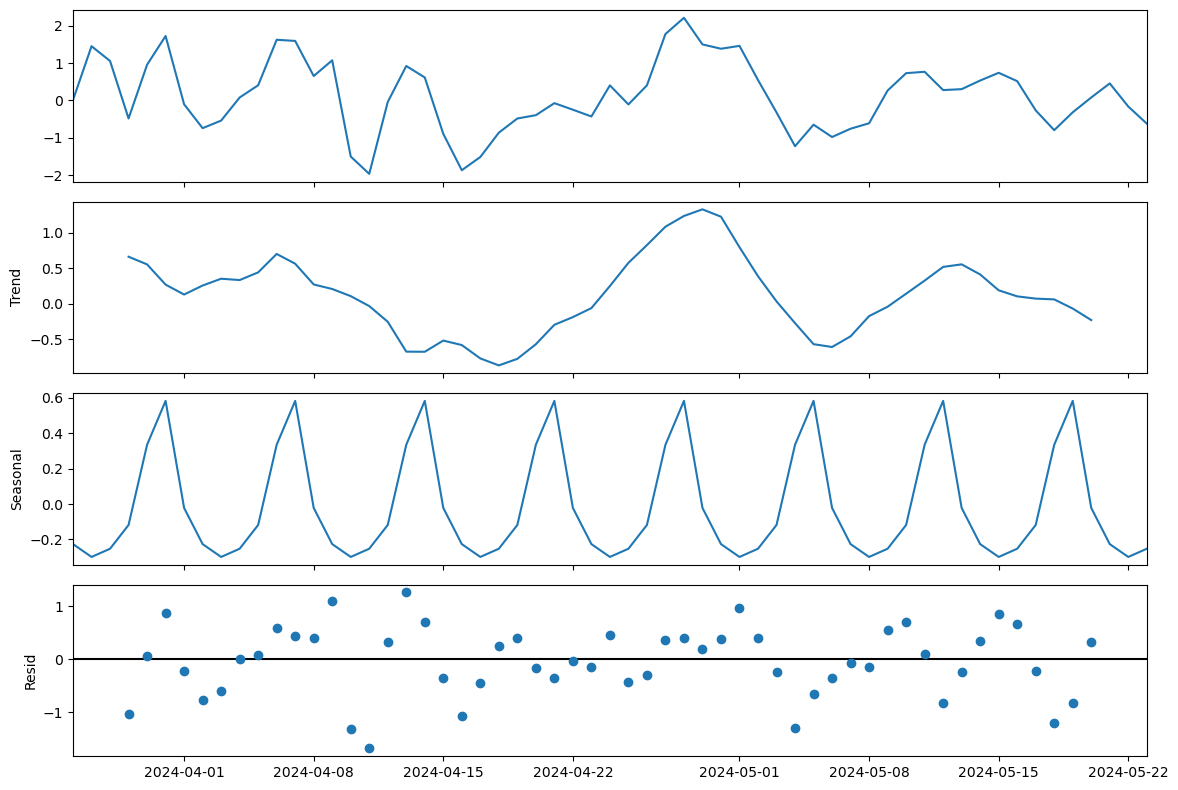

In [21]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(daily_avg, model='additive')
fig = decomposition.plot()
plt.show()

# Training Daten 

In [117]:
train_end=datetime(2024,5,8)
test_end=datetime(2024,5,22)

train_data=daily_avg[:train_end]
test_data=daily_avg[train_end + timedelta(days=1):test_end]

TypeError: 'module' object is not callable. Did you mean: 'datetime.datetime(...)'?